In [1]:
!pip install pydicom
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#load file and print metadata

import pydicom

filename = '1-1.dcm'
RefDs = pydicom.read_file(filename)

print(RefDs)

FileNotFoundError: [Errno 2] No such file or directory: '1-1.dcm'

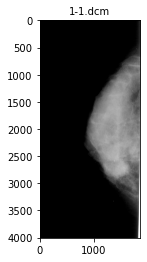

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array
image = ArrayDicom
plt.title(filename, fontsize = 10)
plt.imshow(image, plt.cm.gray)

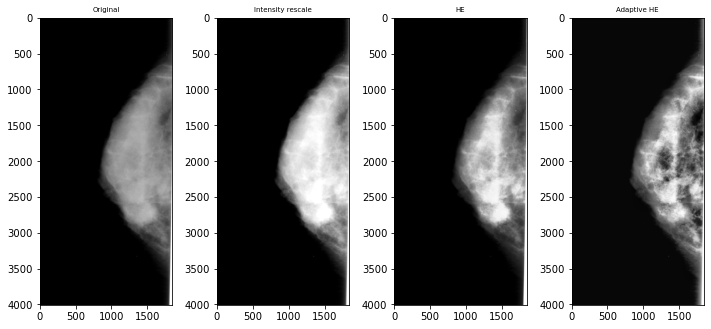

In [ ]:
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
# image processing to prepare for edge detection
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(image, (2, 98))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Equalization
image_eq = exposure.equalize_hist(image)

# Adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.title("Original", fontsize=7)
plt.imshow(image, plt.cm.gray)

plt.subplot(142)
plt.title("Intensity rescale", fontsize=7)
plt.imshow(image_rescale, plt.cm.gray)

plt.subplot(143)
plt.title("HE", fontsize=7)
plt.imshow(image_eq, plt.cm.gray)

plt.subplot(144)
plt.title("Adaptive HE", fontsize=7)
plt.imshow(image_adapteq, plt.cm.gray)
plt.show()

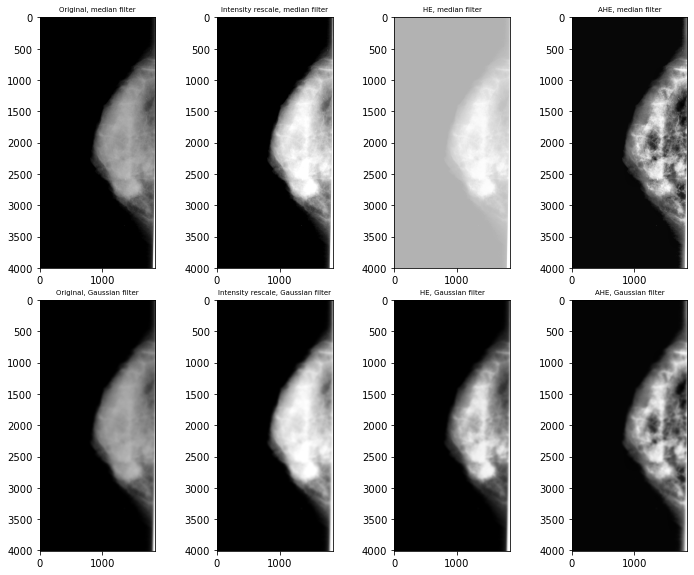

In [ ]:
# smooth...
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

images = [image, image_rescale, image_eq, image_adapteq]
images_med = [medfilt(image, 5) for image in images]
images_gaussian = [gaussian_filter(image, sigma=12) for image in images]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, median filter", fontsize=7)
plt.imshow(images_med[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, median filter", fontsize=7)
plt.imshow(images_med[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, median filter", fontsize=7)
plt.imshow(images_med[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, median filter", fontsize=7)
plt.imshow(images_med[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[0], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[1], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[2], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter", fontsize=7)
plt.imshow(images_gaussian[3], plt.cm.gray)

In [ ]:
import pydicom
import numpy as np
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

def threshold_segmentation(image):
    threshold = threshold_otsu(image)
    
    mask = np.zeros_like(image,'uint8')
    mask[image <= threshold] = 0          
    mask[image > threshold] = 1

    return mask
 

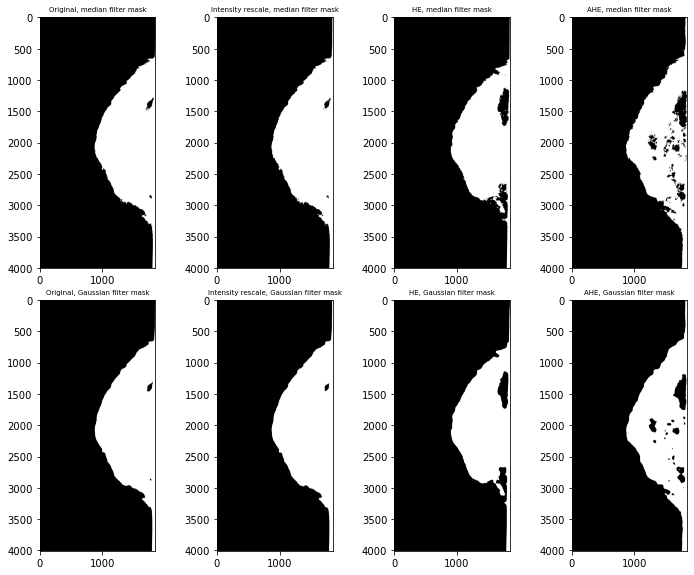

In [ ]:
images = [image, image_rescale, image_eq, image_adapteq]
images_med_threshold = [threshold_segmentation(image) for image in images_med]
images_gaussian_threshold = [threshold_segmentation(image) for image in images_gaussian]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter mask", fontsize=7)
plt.imshow(images_gaussian_threshold[0], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter mask", fontsize=7)
plt.imshow(images_gaussian_threshold[1], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter mask", fontsize=7)
plt.imshow(images_gaussian_threshold[2], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter mask", fontsize=7)
plt.imshow(images_gaussian_threshold[3], plt.cm.gray)

In [ ]:
### Getting the biggest 6 segmentated regions 
import cv2
import matplotlib.cm as cm

def top6regions(mask):
    ret, markers = cv2.connectedComponents(mask)  #this will detect all the regions within the mask
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    inxhist=np.argsort(hist)  #indexes of the sorted histogram
    inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    inxbone2=inxhist[-3] # third last
    inxbone3=inxhist[-4] # fourth last
    inxbone4=inxhist[-5] # fifth last
    inxbone5=inxhist[-6] # sixth last
    ROI2=np.zeros_like(ArrayDicom,'uint8')
    ROI2[np.where(markers==inxbone)]=20  #we turn to 1 only those pixels that are in that second most frequent region
    ROI2[np.where(markers==inxbone2)]=50   #we turn to 1 only those pixels that are in that second most frequent region
    ROI2[np.where(markers==inxbone3)]=80   #we turn to 1 only those pixels that are in that second most frequent region
    ROI2[np.where(markers==inxbone4)]=135   #we turn to 1 only those pixels that are in that second most frequent region
    ROI2[np.where(markers==inxbone5)]=200   #we turn to 1 only those pixels that are in that second most frequent region
    return ROI2
    

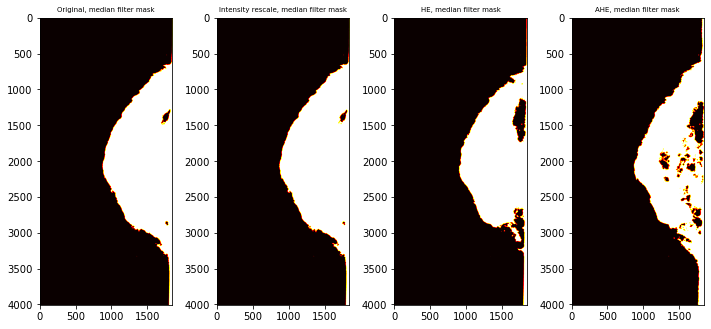

In [ ]:
# Note, we dont use the guassian filtered images here because they do not contain 6 or more regions.
images_med_threshold_6 = [top6regions(image) for image in images_med_threshold]

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.title("Original, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[0], plt.cm.hot)

plt.subplot(142)
plt.title("Intensity rescale, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[1], plt.cm.hot)

plt.subplot(143)
plt.title("HE, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[2], plt.cm.hot)

plt.subplot(144)
plt.title("AHE, median filter mask", fontsize=7)
plt.imshow(images_med_threshold[3], plt.cm.hot)


### Results
The results found here are exploring some different methods for cleaning the data to prepare it for threshold segmentation.

**Processing**  
We performed 3 different processing techniques: intensity rescaling, histogram equalization, and adaptive histogram equalization. We can conclude that from viewing the three different techniques that adaptive histogram equalization is the best method.

**Filtering**  
We performed 2 different filtering techniques to smooth the image: median and Gaussian. The intention with this step was to smooth away some of the fine details before edge detection to increase the chances of the tumour being one of the main features outlined. Although 
the Gaussian filter resulted in a better looking image, it proved to be less useful since it only contained 2 or 3 regions whereas the median filtered masks had many more separate regions.  

**Segmentation**  
We performed 2 different variants of threshold segmentation. The first was to just segment the most common region in the binary mask. The second method was to take the top 6 regions of the binary mask and apply a hot color map to the images. The hot color map gives the best visualization of the different regions.

Overall, the threshold segmentation results for my example image are quite promising. From the data set description, we know this image contains a malignant tumour. From the segmentation, we are able to view areas that are not breast tissue, i.e. the black zones which is the location of the tumour. Using this sample image and adaptive histogram equalization with a median filter, we can see that the malignant tumour is very visible. From this, we can conclude that threshold segmentation is a useful technique for this data-set with regards to tumour detection.

### Next Steps
We will work to compare this mask to a true mask in order to find the DICE coefficient.